In [1]:
import rebound 
print(rebound.__build__)
import numpy as np
import ctypes
import itertools
from ctypes import POINTER, c_double, c_int,byref
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

Nov 18 2018 22:00:56


In [2]:
def sim_copy(self):
    """
    Deep copy of a simulation.
    """
    self.save("tmp.bin")
    return rebound.Simulation.from_file("tmp.bin")
    sim2 = rebound.Simulation()
    for i in range(self.N):
        sim2.add(self.particles[i])
    sim2.t = self.t
    sim2.dt = self.dt
    return sim2
rebound.Simulation.copy = sim_copy

In [3]:
def diffsim(sim1,sim2):
    """
    Returns a meassure for the difference between two simulations.
    """
    m = 0.
    for i in range(sim1.N):
        m = max(m,abs(sim1.particles[i].x-sim2.particles[i].x))
        m = max(m,abs(sim1.particles[i].y-sim2.particles[i].y))
        m = max(m,abs(sim1.particles[i].z-sim2.particles[i].z))
        m = max(m,abs(sim1.particles[i].vx-sim2.particles[i].vx))
        m = max(m,abs(sim1.particles[i].vy-sim2.particles[i].vy))
        m = max(m,abs(sim1.particles[i].vz-sim2.particles[i].vz))
    return m

In [4]:
mercury = ctypes.cdll.LoadLibrary("../mercury/mercury.so")
def mercury_step(self,rcrit=None,algor=1):
    """
    Monkey patch, allowing a REBOUND simulation to call a Mercury integrator
    """
    if self.G!=1.:
        raise ValueError("G must be set to 1.")
    if self.N<2:
        raise ValueError("Number of particles must be > 1.")
    if self.particles[0].m!=1.:
        raise ValueError("Mass of central object must be equal to 1.")
        
    nbod = c_int(self.N)
    nbig = nbod
    NMESS = 1 # number of messages
    CMAX = 1 # number of close encounter minima monitored simultaneously 
    if algor==1:
        step = mercury.mdt_mvsp_

    elif algor==10:
        step = mercury.mdt_hyp_
        if rcrit is None:
            raise ValueError("rcrit must be set for hybrid integrator.")
    else:
        raise ValueError("Integrator not implemented")
              
    step.argtypes = [
        POINTER(c_double), # real*8              time 
        POINTER(c_double), # real*8              tstart
        POINTER(c_double), # real*8              h0
        POINTER(c_double), # real*8              tol
        POINTER(c_double), # real*8              rmax
        POINTER(c_double*3), # real*8(3)           en
        POINTER(c_double*3), # real*8(3)           am
        POINTER(c_double*3), # real*8(3)           jcen
        POINTER(c_double), # real*8              rcen
        POINTER(c_int), # integer             nbod
        POINTER(c_int), # integer             nbig
        POINTER(c_double*nbod.value), # real*8(nbod)        m
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      x
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      v
        POINTER((c_double*3)*nbod.value), # real*8(3,nbod)      s
        POINTER(c_double*nbod.value), # real*8(nbod)        rphys
        POINTER(c_double*nbod.value), # real*8(nbod)        rcrit
        POINTER(c_double*nbod.value), # real*8(nbod)        rce
        POINTER(c_int), # integer(nbod)       stat
        POINTER((c_double*4)*nbod.value), # real*8(4,nbod)      ngf
        POINTER(c_int), # integer             algor
        POINTER(c_int*8),# integer(8)          opt
        POINTER(c_int), # integer             dtflag
        POINTER(c_int), # integer             ngflag
        POINTER(c_int), # integer             opflag
        POINTER(c_int), # integer             colflag
        POINTER(c_int), # integer             nclo
        POINTER(c_int*CMAX), # integer(CMAX)       iclo
        POINTER(c_int*CMAX), # integer(CMAX)       jclo
        POINTER(c_double*CMAX), # real*8(CMAX)        dclo
        POINTER(c_double*CMAX), # real*8(CMAX)        tclo
        POINTER(c_double*CMAX), # real*8(CMAX)        ixvclo
        POINTER(c_double*CMAX), # real*8(CMAX)        jxvclo
        POINTER(c_int*NMESS),# integer(NMESS)     lmem
        ]

    time = c_double(0.)
    tstart = c_double(0.)
    h0 = c_double(self.dt)
    tol = c_double(1e-16)
    rmax = c_double(100.)
    DoubleArray3 = c_double * 3
    en = DoubleArray3(0.,0.,0.)
    am = DoubleArray3(0.,0.,0.)
    jcen = DoubleArray3(0.,0.,0.)
    rcen = c_double(0.)
    DoubleArrayNBOD = c_double * nbod.value
    DoubleArray3NBOD = (c_double * 3)* nbod.value
    _m = []
    _x = []
    _v = []
    _s = []
    for p in self.particles:
        _m.append(p.m)
        _x.append(DoubleArray3(p.x,p.y,p.z))
        _v.append(DoubleArray3(p.vx,p.vy,p.vz))
        _s.append(DoubleArray3(0.,0.,0.))
    m = DoubleArrayNBOD(*_m)
    x = DoubleArray3NBOD(*_x)
    v = DoubleArray3NBOD(*_v)
    s = DoubleArray3NBOD(*_s)
    rphys = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    if rcrit is None:
        rcrit = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    else:
        rcrit = DoubleArrayNBOD(*rcrit) 
    rce = DoubleArrayNBOD(*[0. for i in range(nbod.value)])
    stat = c_int(0)
    DoubleArray4 = (c_double * 4)
    DoubleArray4NBOD = (c_double * 4) * nbod.value
    ngf = DoubleArray4NBOD(*[DoubleArray4(0,0,0,0) for i in range(nbod.value)])
    algor = c_int(algor)
    IntArray8 = c_int*8
    opt = IntArray8(0,1,1,2,0,1,0,0)
    dtflag = c_int(0)
    ngflag = c_int(0)
    opflag = c_int(0)
    colflag = c_int(0)
    nclo = c_int(1)
    iclo = (c_int*1)(0)
    jclo = (c_int*1)(0)
    dclo = (c_double*1)(0.)
    tclo = (c_double*1)(0.)
    ixvclo = (c_double*1)(0.)
    jxvclo = (c_double*1)(0.)
    lmem = (c_int*1)(0)

    step(byref(time), byref(tstart), byref(h0), byref(tol), byref(rmax), byref(en), byref(am), byref(jcen), byref(rcen),
         byref(nbod), byref(nbig), byref(m), byref(x), byref(v), byref(s), byref(rphys), byref(rcrit), byref(rce), byref(stat),
         byref(ngf), byref(algor), byref(opt), byref(dtflag), byref(ngflag), byref(opflag), byref(colflag), byref(nclo),
         byref(iclo), byref(jclo), byref(dclo), byref(tclo), byref(ixvclo), byref(jxvclo), byref(lmem))
    for i,p in enumerate(self.particles):
        self.particles[i].x = x[i][0]
        self.particles[i].y = x[i][1]
        self.particles[i].z = x[i][2]
        self.particles[i].vx = v[i][0]
        self.particles[i].vy = v[i][1]
        self.particles[i].vz = v[i][2]
    self.t += self.dt
rebound.Simulation.mercury_step = mercury_step

In [5]:
def _step_inertial(self,algo):
    dt = self.dt
    com = self.calculate_com()
    self.move_to_hel() # Mercury needs to be in hel
    if algo == "mercury":
        self.mercury_step(rcrit=rcrit, algor=10)
    elif algo == "mercurymvs":
        self.mercury_step(algor=1)        
    elif algo == "mercurius":
        self.integrator = "mercurius"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.ri_mercurius.kmode = 0
        
        DoubleArrayNBOD = c_double * sim.N
        rcrit_p = DoubleArrayNBOD(*rcrit) 
        rebound.clibrebound.reb_set_rhill(byref(self),c_int(sim.N),byref(rcrit_p))
        self.step()
    elif algo == "mercurius-der":
        self.integrator = "mercurius"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.ri_mercurius.kmode = 1
        
        DoubleArrayNBOD = c_double * sim.N
        rcrit_p = DoubleArrayNBOD(*rcrit) 
        rebound.clibrebound.reb_set_rhill(byref(self),c_int(sim.N),byref(rcrit_p))
        self.step()
    elif algo == "mercurius-lin":
        self.integrator = "mercurius"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.ri_mercurius.kmode = 2
        
        DoubleArrayNBOD = c_double * sim.N
        rcrit_p = DoubleArrayNBOD(*rcrit) 
        rebound.clibrebound.reb_set_rhill(byref(self),c_int(sim.N),byref(rcrit_p))
        self.step()
    elif algo == "mercurius-pol3":
        self.integrator = "mercurius"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.ri_mercurius.kmode = 3
        
        DoubleArrayNBOD = c_double * sim.N
        rcrit_p = DoubleArrayNBOD(*rcrit) 
        rebound.clibrebound.reb_set_rhill(byref(self),c_int(sim.N),byref(rcrit_p))
        self.step()        
    elif algo == "mercurius-wolf":
        self.integrator = "mercurius"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.ri_mercurius.kmode = 4
        
        DoubleArrayNBOD = c_double * sim.N
        rcrit_p = DoubleArrayNBOD(*rcrit) 
        rebound.clibrebound.reb_set_rhill(byref(self),c_int(sim.N),byref(rcrit_p))
        self.step()                
    elif algo == "whfast":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "jacobi"
        self.step()
    elif algo == "whfast-cor":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "jacobi"
        self.ri_whfast.corrector = 11
        self.step()
    elif algo == "whfastdh":
        self.integrator = "whfast"
        self.ri_whfast.coordinates = "democraticheliocentric"
        self.step()    
    elif algo == "ias15":
        self.integrator = "ias15"
        self.integrate(self.t+self.dt,exact_finish_time=1)            
        self.dt = dt
    else:
        raise ValueError("Not defined")

    self.move_to_com()
    for i in range(sim.N):
        self.particles[i].x += com.x + dt*com.vx
        self.particles[i].y += com.y + dt*com.vy
        self.particles[i].z += com.z + dt*com.vz
        self.particles[i].vx += com.vx
        self.particles[i].vy += com.vy
        self.particles[i].vz += com.vz
rebound.Simulation.step_inertial = _step_inertial    

In [6]:
def setup_sim():
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(a=1,e=0.1,f=0.9,omega=4.9,m=0.001)
    sim.add(a=1.1,omega=0.3,f=0.5,e=0.2,m=0.001)
    sim.dt = 0.05
    return sim
# calculate mercurius rcrit, then use it later for mercury
sim = setup_sim()
rcrit = [0]
for i in range(1,sim.N):    
    rcrit.append(5.*sim.particles[i].rhill)
rcrit

[0, 0.3466806371753172, 0.38122166933751644]

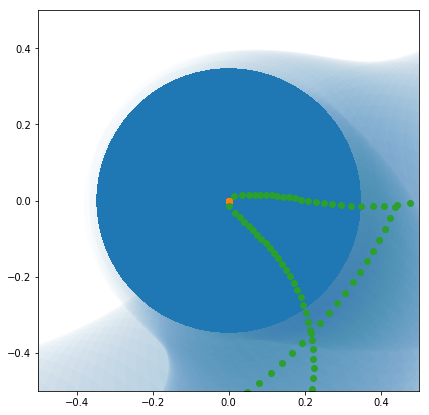

In [7]:
"""Plotting the test orbit"""
fig, ax = plt.subplots(1,1,figsize=(7,7))        

sim = setup_sim()
patches = [[] for i in range(sim.N)]
steps = 300
xyz = np.zeros((steps,sim.N,3))
for k in range(steps):
    sim.step_inertial("ias15")
    for i in range(sim.N):
        refid = 1
        ref = sim.particles[refid]
        xyz[k][i] = [sim.particles[i].x-ref.x, sim.particles[i].y-ref.y, sim.particles[i].z-ref.z]
        if rcrit[i]>0.:
            circle = Circle((xyz[k][i][0], xyz[k][i][1]), rcrit[i])
            patches[i].append(circle)
        
for i in range(sim.N):        
    p = PatchCollection(patches[i], alpha=0.02)
    ax.add_collection(p)

ax.set_aspect("equal")
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])
for i in range(sim.N):
    ax.scatter(xyz[:,i,0],xyz[:,i,1]);

In [8]:
def _get_min_distance(self):
    m = 0.
    for i in range(self.N):
        for j in range(i+1,self.N):
            dx = self.particles[i].x - self.particles[j].x
            dy = self.particles[i].y - self.particles[j].y
            dz = self.particles[i].z - self.particles[j].z
            s = dx**2+dy**2+dz**2
            if m>s or m==0.:
                m = s 
    return np.sqrt(s)
rebound.Simulation.get_min_distance = _get_min_distance

In [9]:
def symplecticity(sim,algo):
    Ndim = sim.N*6
    Omega1 = np.concatenate((np.zeros((Ndim//2,Ndim//2)),np.identity(Ndim//2)),axis=1)
    Omega2 = np.concatenate((-np.identity(Ndim//2),np.zeros((Ndim//2,Ndim//2))),axis=1)
    Omega = np.concatenate((Omega1,Omega2))
    J = np.zeros((Ndim,Ndim))
    
    
    sample_points = [-2.,-1.,+1.,+2.] # order 4
    delta = 1e-4
    #sample_points = [-1.,+1.] # order 2
    #delta = 1e-5
    
    data_p = np.zeros(Ndim) # will be reused
    data_m = np.zeros(Ndim) # will be reused
    f = np.zeros((len(sample_points),Ndim))
    
    for i in range(Ndim):
        # Juggling indicies to convert from xyzxyzvxvyvzvxvyvz to xyzvxvyvzxyzvxvyvz
        i_p = (i//3) % (Ndim//6) # particle index
        i_c = i%3 # positions
        scale = 1. 
        if i>=Ndim//2:
            i_c += 3 # momenta
            scale = sim.particles[i_p].m # adjust scale for momenta
           

        for s,sample in enumerate(sample_points):        
            sim_m = sim.copy()        
            sim_m.serialize_particle_data(xyzvxvyvz=data_m)        
            data_m[6*i_p+i_c] += sample*delta/scale
            sim_m.set_serialized_particle_data(xyzvxvyvz=data_m)
            sim_m.step_inertial(algo) 
            sim_m.serialize_particle_data(xyzvxvyvz=data_m)
            f[s] = data_m
        
        if len(sample_points)==2:
            data_d = (-1*f[0]+1*f[1])/(2.*delta)
        if len(sample_points)==4:
            data_d = (1*f[0]-8*f[1]+8*f[2]-1*f[3])/(12.*delta)    

        for j in range(Ndim):
            j_p = (j//3) % (Ndim//6) # particle index
            j_c = j%3 # positions
            scale = 1.
            if j>=Ndim//2:
                j_c += 3 # momenta
                scale = sim.particles[j_p].m
            J[i][j] = data_d[6*j_p+j_c]*scale
        
    return np.sum(np.abs(np.dot(np.dot(J.T,Omega),J)-Omega))

In [10]:
%%time
algos = ["ias15","mercury","mercurius","mercurius-der","mercurius-wolf"] #,"mercurius-lin","mercurius-pol3","whfast","whfast-cor"]

steps = 150
energy = np.zeros([len(algos),steps])
symple = np.zeros([len(algos),steps])
distan = np.zeros([len(algos),steps])
times = np.zeros(steps)
simdiffmatrix = np.zeros([len(algos),len(algos),steps])
sims = []
for i,algo in enumerate(algos):
    sims.append(setup_sim())
e0 = sims[0].calculate_energy()
for k in range(steps):
    for i,algo in enumerate(algos):
        symple[i,k] = symplecticity(sims[i],algo)
        sims[i].step_inertial(algo)
        energy[i,k] = np.abs((e0-sims[i].calculate_energy())/e0)
        distan[i,k] = sims[i].get_min_distance()
        times[k] = sims[i].t
    for i,algo1 in enumerate(algos):
        for j,algo2 in enumerate(algos):
            if i!=j:
                if j>i:
                    simdiffmatrix[i,j,k] = diffsim(sims[i],sims[j])     
                else:
                    simdiffmatrix[i,j,k] = simdiffmatrix[j,i,k]

CPU times: user 18.6 s, sys: 12 s, total: 30.6 s
Wall time: 37.4 s


In [11]:
def K_poly(r,rcrit):
    y = (r-0.1*rcrit)/(0.9*rcrit)
    if y<0.: return 0
    if y>1.: return 1.
    return 10.*y**3 - 15.*y**4 + 6*y**5

def K_poly_d(r,rcrit):
    y = (r-0.1*rcrit)/(0.9*rcrit)
    if y<0.: return 0
    if y>1.: return 0.
    return 1./(0.9*rcrit)*(3.*10.*y**2 - 4.*15.*y**3 + 5.*6.*y**4)


distan_ias15 = distan[algos.index("ias15")]
K_poly_list = np.zeros(steps)
K_poly_d_list = np.zeros(steps)
for i in range(steps):
    K_poly_list[i] = K_poly(distan_ias15[i],np.max(rcrit))
    K_poly_d_list[i] = K_poly_d(distan_ias15[i],np.max(rcrit))

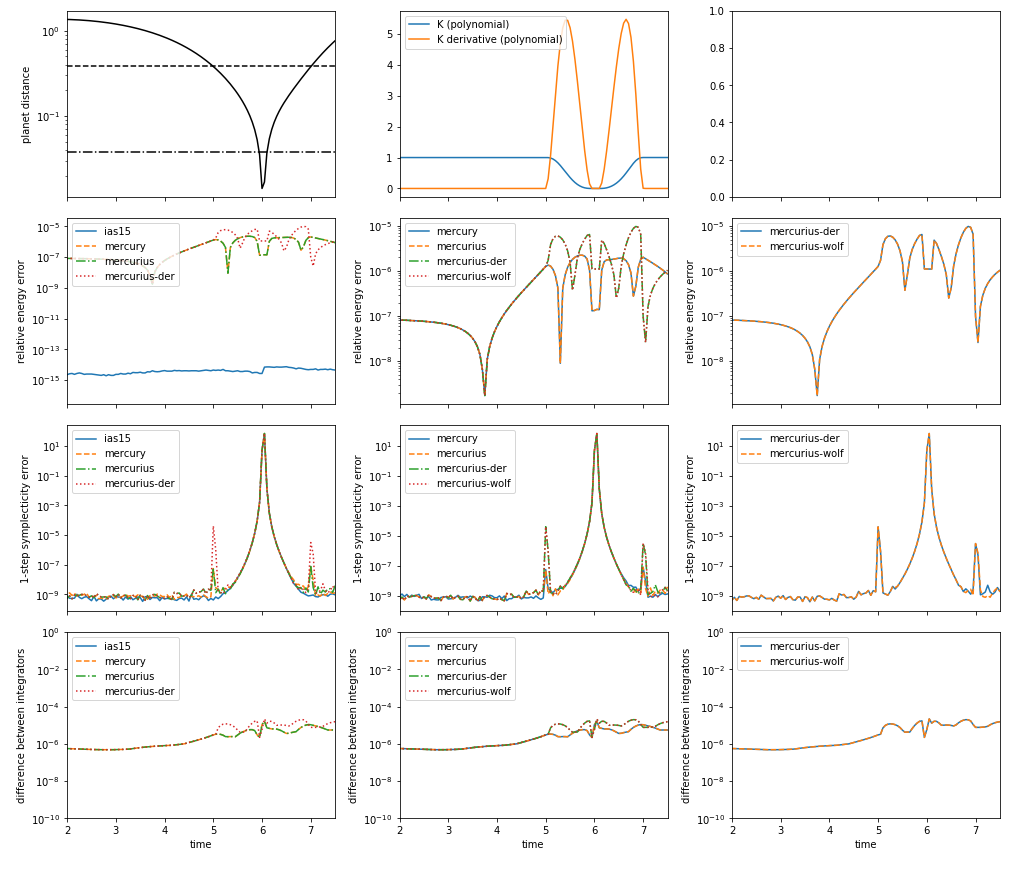

In [13]:
fig, ax = plt.subplots(4,3,figsize=(14,12), sharex=True)
for _a in ax:
    for __a in _a:
        __a.set_xlim([2.,times[-1]])
a = 0

ax[a][0].set_ylabel("planet distance");
d = distan[algos.index("ias15")]
#ax[a].set_ylim([0.,np.max(d)*1.1])
ax[a][0].set_yscale("log")
ax[a][0].plot(times,d,color="black")
rcritmax = np.max(rcrit)
ax[a][0].axhline(rcritmax,ls="--",color="black")
ax[a][0].axhline(rcritmax*0.1,ls="-.",color="black")
ax[a][0].annotate('$r_{crit}$', xy=(1, rcritmax*1.15))
ax[a][0].annotate('$0.1 r_{crit}$', xy=(1, rcritmax*.115))


#ax[a][1].set_ylabel("$K(r)$, $\frac{\partial K}{\partial r}$");
#ax[a][1].set_ylim([-5.,5.4])
ax[a][1].plot(times,K_poly_list,label="K (polynomial)")
ax[a][1].plot(times,K_poly_d_list,label="K derivative (polynomial)")
rcritmax = np.max(rcrit)
ax[a][1].legend(loc="upper left");



algos_c = [algos[:4], algos[1:5], algos[3:5]]


for c in range(3):
    a = 1
    linecycler = itertools.cycle(["-","--","-.",":"])
    ax[a][c].set_yscale("log")
    for algo in algos_c[c]:
        ax[a][c].plot(times,np.maximum(energy[algos.index(algo)],1e-16),next(linecycler),label=algo)
    ax[a][c].legend(loc="upper left");
    ax[a][c].set_ylabel("relative energy error");

    a = 2
    linecycler = itertools.cycle(["-","--","-.",":"])
    ax[a][c].set_yscale("log")
    #ax[a][c].set_ylim([1e-7,1e-2])
    for algo in algos_c[c]:
         ax[a][c].plot(times,symple[algos.index(algo)],next(linecycler),label=algo)
    ax[a][c].set_ylabel("1-step symplecticity error");
    ax[a][c].legend(loc="upper left");

    a = 3
    linecycler = itertools.cycle(["-","--","-.",":"])
    ax[a][c].set_yscale("log")
    ax[a][c].set_ylim([1e-10,1])
    for algo in algos_c[c]:
         ax[a][c].plot(times,simdiffmatrix[algos.index(algo)][algos.index("ias15")],next(linecycler),label=algo)
    ax[a][c].set_ylabel("difference between integrators");
    ax[a][c].legend(loc="upper left");




    ax[-1][c].set_xlabel("time")
fig.tight_layout()


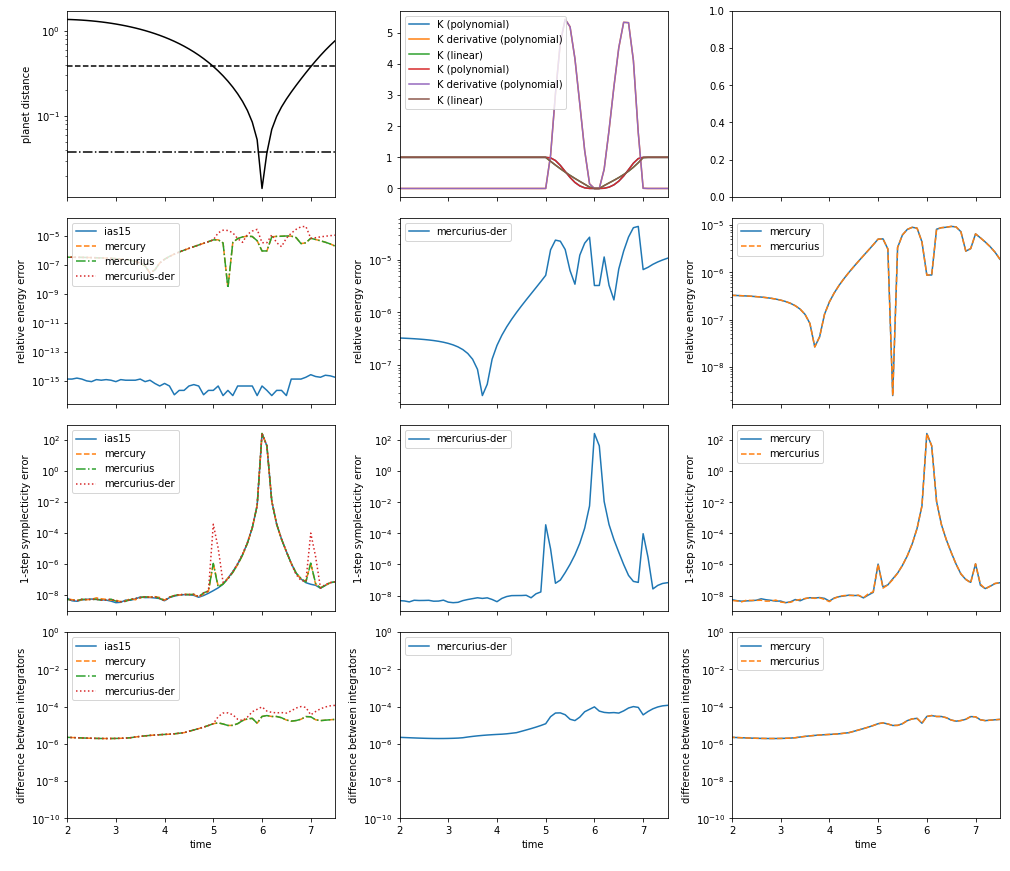

In [38]:
fig, ax = plt.subplots(4,3,figsize=(14,12), sharex=True)
for _a in ax:
    for __a in _a:
        __a.set_xlim([2.,times[-1]])
a = 0

ax[a][0].set_ylabel("planet distance");
d = distan[algos.index("ias15")]
#ax[a].set_ylim([0.,np.max(d)*1.1])
ax[a][0].set_yscale("log")
ax[a][0].plot(times,d,color="black")
rcritmax = np.max(rcrit)
ax[a][0].axhline(rcritmax,ls="--",color="black")
ax[a][0].axhline(rcritmax*0.1,ls="-.",color="black")
ax[a][0].annotate('$r_{crit}$', xy=(1, rcritmax*1.15))
ax[a][0].annotate('$0.1 r_{crit}$', xy=(1, rcritmax*.115))


#ax[a][1].set_ylabel("$K(r)$, $\frac{\partial K}{\partial r}$");
#ax[a][1].set_ylim([-5.,5.4])
ax[a][1].plot(times,K_poly_list,label="K (polynomial)")
ax[a][1].plot(times,K_poly_d_list,label="K derivative (polynomial)")
ax[a][1].plot(times,K_lin_list,label="K (linear)")
rcritmax = np.max(rcrit)
ax[a][1].legend(loc="upper left");



ax[a][1].plot(times,K_poly_list,label="K (polynomial)")
ax[a][1].plot(times,K_poly_d_list,label="K derivative (polynomial)")
ax[a][1].plot(times,K_lin_list,label="K (linear)")
rcritmax = np.max(rcrit)
ax[a][1].legend(loc="upper left");




algos_c = [algos[:4], algos[3:5], algos[1:3]]


for c in range(3):
    a = 1
    linecycler = itertools.cycle(["-","--","-.",":"])
    ax[a][c].set_yscale("log")
    for algo in algos_c[c]:
        ax[a][c].plot(times,np.maximum(energy[algos.index(algo)],1e-16),next(linecycler),label=algo)
    ax[a][c].legend(loc="upper left");
    ax[a][c].set_ylabel("relative energy error");

    a = 2
    linecycler = itertools.cycle(["-","--","-.",":"])
    ax[a][c].set_yscale("log")
    #ax[a][c].set_ylim([1e-7,1e-2])
    for algo in algos_c[c]:
         ax[a][c].plot(times,symple[algos.index(algo)],next(linecycler),label=algo)
    ax[a][c].set_ylabel("1-step symplecticity error");
    ax[a][c].legend(loc="upper left");

    a = 3
    linecycler = itertools.cycle(["-","--","-.",":"])
    ax[a][c].set_yscale("log")
    ax[a][c].set_ylim([1e-10,1])
    for algo in algos_c[c]:
         ax[a][c].plot(times,simdiffmatrix[algos.index(algo)][algos.index("ias15")],next(linecycler),label=algo)
    ax[a][c].set_ylabel("difference between integrators");
    ax[a][c].legend(loc="upper left");




    ax[-1][c].set_xlabel("time")
fig.tight_layout()

